# Исследование статистических свойств распределения логарифмических доходностей российских акций

### Введение

Статистические свойства доходностей финансовых активов важны для управлении рисками, ценообразовании деривативов и построении торговых стратегий. Традиционная модель Блэка–Шоулза предполагает, что цены активов следуют геометрическому броуновскому движению, откуда логарифмические доходности:


$$ r_t = \ln \left(\frac{P_t}{P_{t-1}}\right) $$

должны быть независимо и нормально распределены.

Однако, в современной практике, было показано, что **эмпирические распределения доходностей характеризуются тяжелыми хвостами, асимметрией и скачками волатильности**, что противоречит нормальной модели. Это приводит к систематическому недооцениванию риска при использовании нормального распределения.

**Цель исследования:** проверить, насколько логдоходности российских акций соответствуют нормальному распределению, а также рассмотреть другие распределения и сравнить их.

## 1. Импорт библиотек

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.stats import skew, kurtosis, shapiro, jarque_bera, norm, t, laplace, kstest

## 2. Анализ одной акции (пример: Сбербанк, 2024)

In [2]:
data = pd.read_csv("SBER.csv")
data["TIMESTAMP"] = pd.to_datetime(data["TIMESTAMP"])

### 2.1. График цены, распределение логдоходностей 

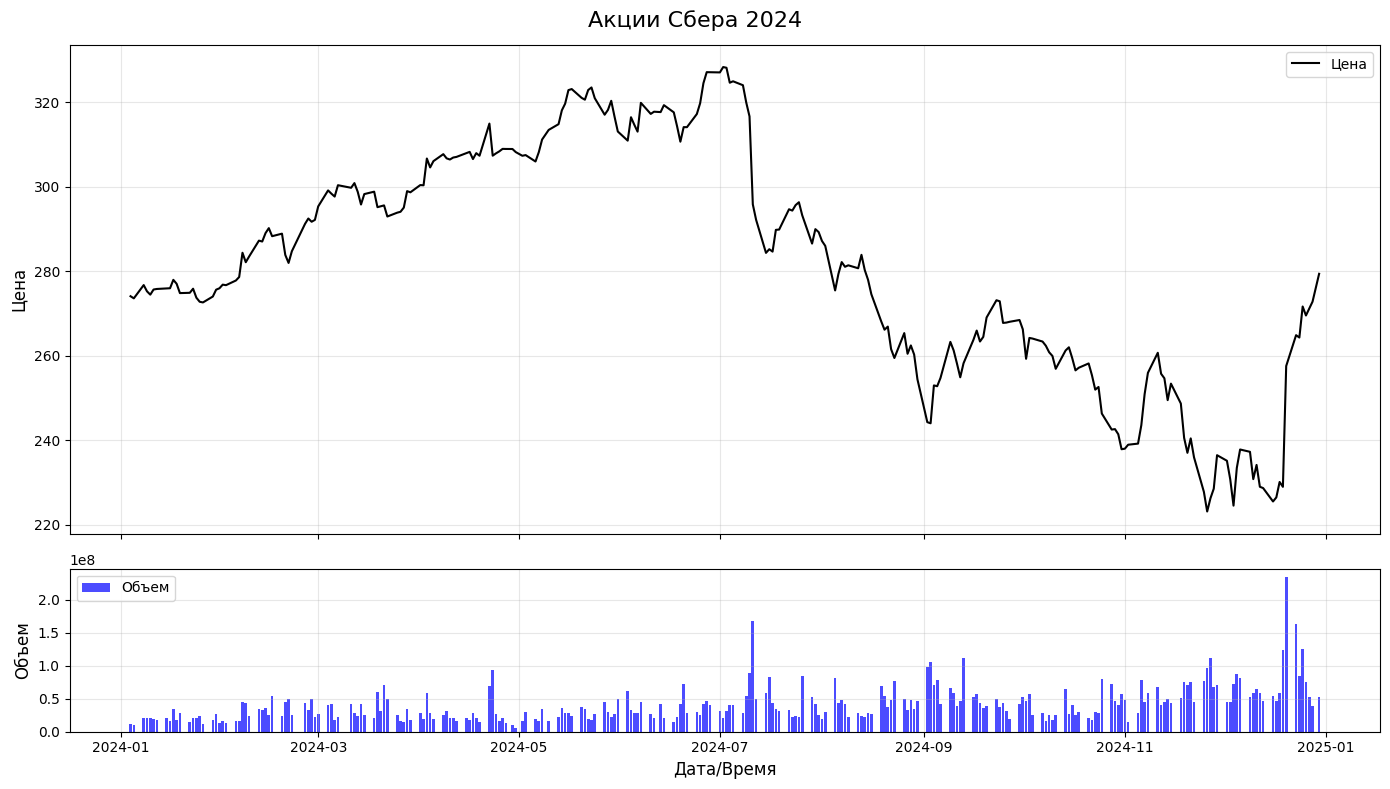

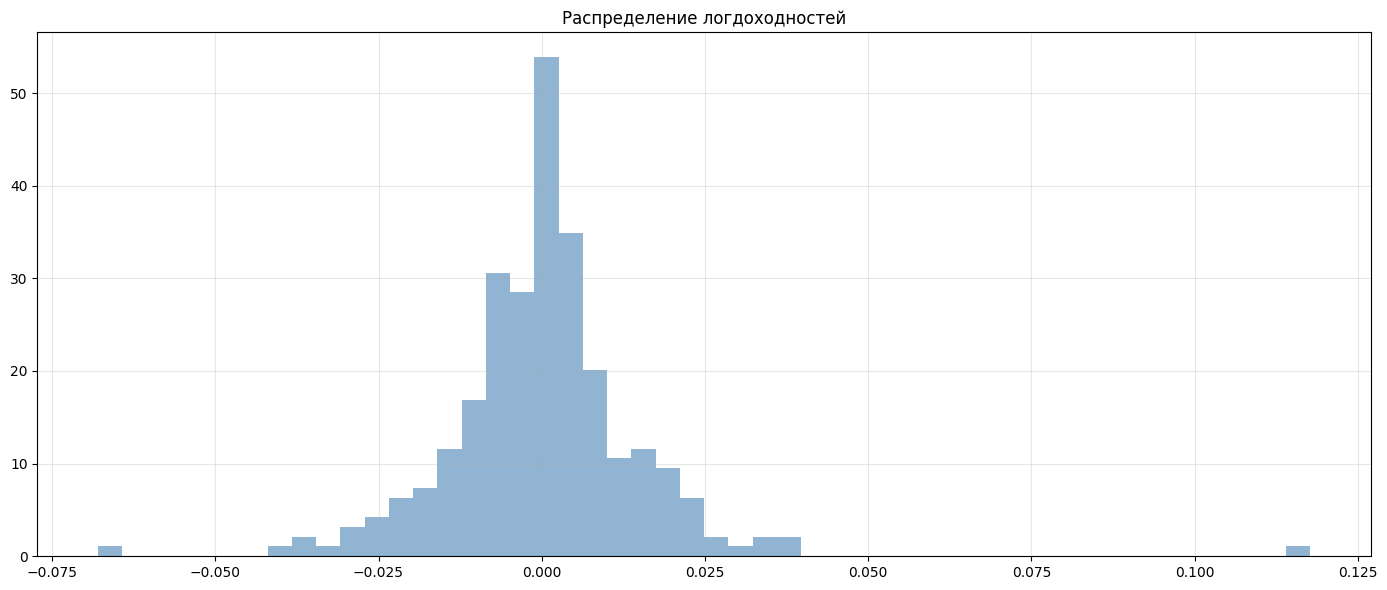

In [3]:
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(14, 8), gridspec_kw={'height_ratios': [3, 1]}, sharex=True)
ax1.plot(data["TIMESTAMP"], data['PRICE'], color='black', linewidth=1.5, label='Цена')
ax1.set_ylabel('Цена', fontsize=12)
ax1.grid(True, alpha=0.3)
ax1.legend()
ax2.bar(data["TIMESTAMP"], data['VOLUME'], color='blue', alpha=0.7, label='Объем')
ax2.set_ylabel('Объем', fontsize=12)
ax2.grid(True, alpha=0.3)
ax2.legend()
ax2.set_xlabel('Дата/Время', fontsize=12)
fig.suptitle('Акции Сбера 2024', fontsize=16)
plt.tight_layout()
plt.show()

plt.figure(figsize=[14,6])
plt.title("Распределение логдоходностей")
plt.hist(data["LOGRET"], bins=50, density=True, alpha=0.6, color="steelblue")
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

### 2.2. Проверка гипотезы о нормальности

Рассматриваются основные характеристики распределения:

- асимметрия
- эксцесс (для нормального распределения равен 3)
- тесты Shapiro–Wilk и Jarque–Bera

Если p-value мало — нормальность отвергается.

In [ ]:
logret = data["LOGRET"]
mean = logret.mean()
std = logret.std()
skw = skew(logret)
kurt_val = kurtosis(logret, fisher=False)
print(f"Среднее: {mean:.6f}, Стд: {std:.6f}, Ассиметрия: {skw:.6f}, Эксцесс: {kurt_val:.6f}")
sw_stat, sw_p = shapiro(logret)
jb_stat, jb_p = jarque_bera(logret)
print(f"Shapiro-Wilk p-value: {sw_p:.4e}")
print(f"Jarque-Bera p-value: {jb_p:.4e}")

Среднее: 0.000069, Стд: 0.015272, Ассиметрия: 1.404125, Эксцесс: 17.344189
Shapiro-Wilk p-value: 1.0841e-13
Jarque-Bera p-value: 0.0000e+00


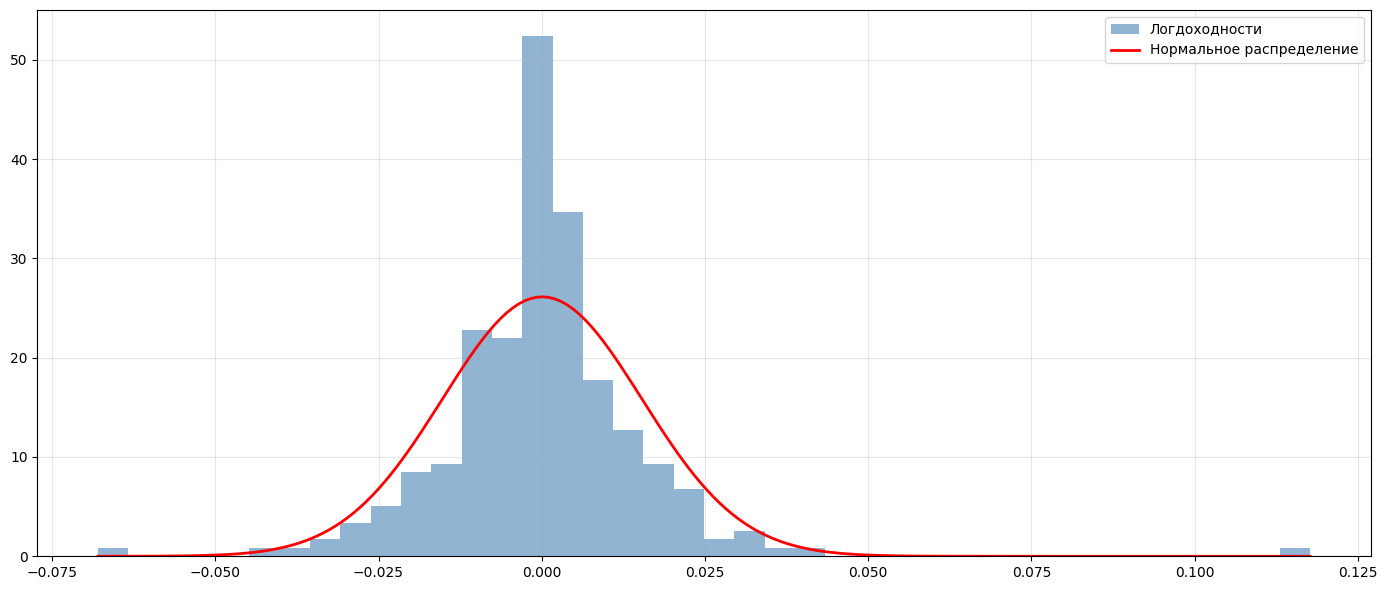

In [5]:
plt.figure(figsize=[14,6])
plt.hist(data["LOGRET"], bins=40, density=True, alpha=0.6, color="steelblue", label = "Логдоходности")
plt.grid(True, alpha=0.3)

x = np.linspace(data["LOGRET"].min(), data["LOGRET"].max(), 200)
plt.plot(x, norm.pdf(x, loc=mean, scale=std), color="red", lw=2, label="Нормальное распределение")
plt.legend()
plt.tight_layout()
plt.show()

#### Вывод по нормальности

- Ассиметрия положительна, распределение сдвинуто вправо
- Эксцесс сильно больше 3, имеются толстые хвосты
- p-value статистических тестов 0, гипотеза о нормальности отвергается

Логдоходности не распределены нормально, а имеют толстые хвосты и ассиметрию.

### 2.3. Проверка согласия с t-распределением

t-распределение традиционно используется в финансовых данных благодаря тяжёлым хвостам. Параметры оценены методом максимального правдоподобия. Проверяются:

- тест Колмогорова–Смирнова;
- ошибка в хвостах на уровне $ ∣ r_t ∣ > 3σ $

In [6]:
df_t, loc_t, scale_t = t.fit(logret)
kst_stat, kst_p = kstest(logret, 't', args=(df_t, loc_t, scale_t))

threshold = 3*std
emp_tail = np.mean(np.abs(logret) > threshold)
norm_tail = 2*(1-norm.cdf(threshold, loc=mean, scale=std))
t_tail = 2*(1-t.cdf(threshold, df=df_t, loc=loc_t, scale=scale_t))

tail_error_normal = abs(emp_tail - norm_tail)
tail_error_t = abs(emp_tail - t_tail)

print(f"t-распределение: df={df_t:.2f}, loc={loc_t:.6f}, scale={scale_t:.6f}")
print(f"K-S тест p-value: {kst_p:.4f}")
print(f"Tail |x|>3σ: эмпирически={emp_tail:.6f}, нормальное={norm_tail:.6f}, t={t_tail:.6f}")

t-распределение: df=2.93, loc=-0.000080, scale=0.009099
K-S тест p-value: 0.7772
Tail |x|>3σ: эмпирически=0.007843, нормальное=0.002740, t=0.015965


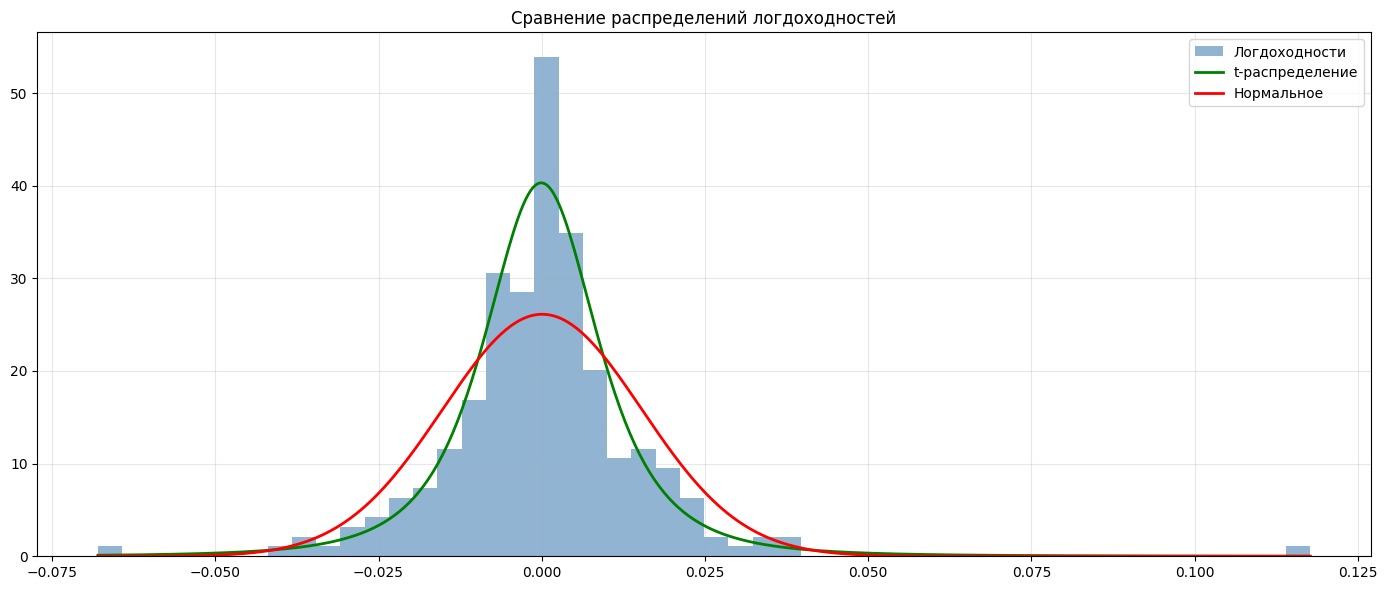

In [7]:
plt.figure(figsize=(14,6))
plt.hist(data["LOGRET"], bins=50, density=True, alpha=0.6, color="steelblue", label="Логдоходности")
x = np.linspace(min(data["LOGRET"]), max(data["LOGRET"]), 500)
plt.plot(x, t.pdf(x, df_t, loc_t, scale_t), color="green", lw=2, label="t-распределение")
plt.plot(x, norm.pdf(x, mean, std), color="red", lw=2, label="Нормальное")
plt.grid(True, alpha=0.3)
plt.legend()
plt.title("Сравнение распределений логдоходностей")
plt.tight_layout()
plt.show()

#### Вывод по t-распределению

- Число степеней свободы ~3, сильно тяжелые хвосты
- Тест Колмогорова-Смирнова не отвергает t-распределение
- t-модель лучше описывает экстремальные изменения, чем нормальное распределение

## 3. Распределение Лапласа

Распределение Лапласа (двойное экспоненциальное):

- имеет более высокий пик
- хвосты толще нормальных, но обычно тоньше, чем у t
- часто хорошо описывает центр распределения

In [12]:
lap_params = laplace.fit(data["LOGRET"])
lap_kst, lap_p = kstest(data["LOGRET"], 'laplace', args=lap_params)
print(f"Laplace: loc={lap_params[0]:.6f}, scale={lap_params[1]:.6f}, K-S p-value={lap_p:.4f}")

Laplace: loc=0.000241, scale=0.009922, K-S p-value=0.8354


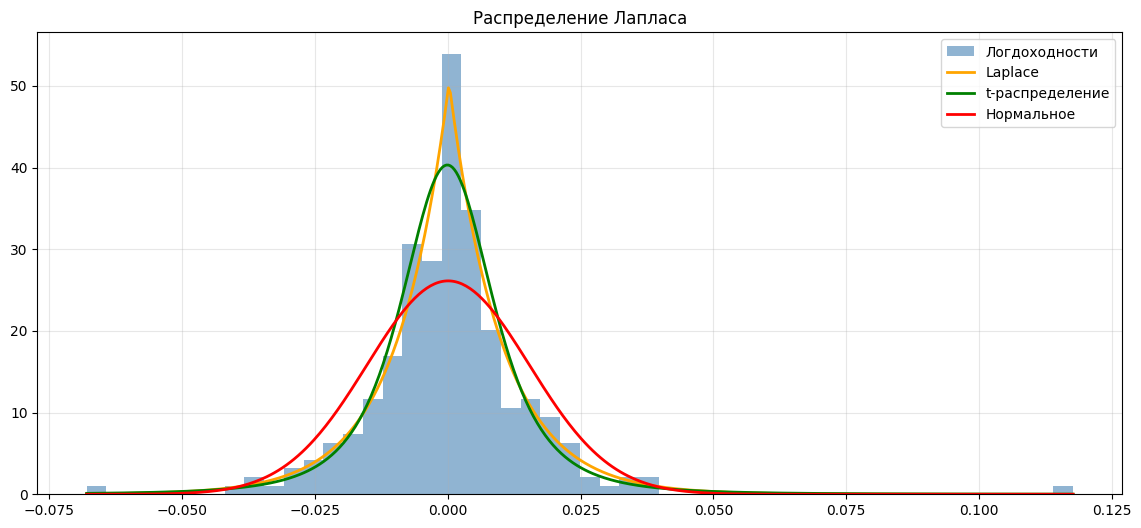

In [13]:
plt.figure(figsize=(14,6))
plt.hist(logret, bins=50, density=True, alpha=0.6, color='steelblue', label='Логдоходности')
plt.plot(x, laplace.pdf(x, *lap_params), color='orange', lw=2, label='Laplace')
plt.plot(x, t.pdf(x, df_t, loc_t, scale_t), color="green", lw=2, label="t-распределение")
plt.plot(x, norm.pdf(x, mean, std), color="red", lw=2, label="Нормальное")
plt.grid(True, alpha=0.3)
plt.legend()
plt.title('Распределение Лапласа')
plt.show()

#### Вывод по распределению Лапласа
– тест Колмогорова–Смирнова даёт высокое p-value ≈ 0.84 — модель в целом согласуется с данными;
– центральная часть распределения описывается хорошо благодаря острому пику;
– хвосты моделируются хуже, чем у t-распределения — его подгонка по экстремальным значениям остаётся более надёжной.

## 3. Проверка нескольких акций

Проверка на акциях других компаний: SBER, GAZP, LKOH, VTBR.

Для каждой акции оценивается:

- согласие с нормальным распределением
- согласие с t
- согласие с Лапласом
- ошибки моделирования хвостов

In [ ]:
tickers = ["SBER", "GAZP", "LKOH", "VTBR"]
results = []

for ticker in tickers:
    df = pd.read_csv(f"{ticker}.csv")
    logret = df["LOGRET"]
    mean = logret.mean()
    std = logret.std()
    sw_stat, p_normal = shapiro(logret)
    df_t, loc_t, scale_t = t.fit(logret)
    _, p_t = kstest(logret, 't', args=(df_t, loc_t, scale_t))
    lap_params = laplace.fit(logret)
    _, p_lap = kstest(logret, 'laplace', args=lap_params)
    threshold = 3 * std
    emp_tail = np.mean(np.abs(logret) > threshold)
    norm_tail = 2 * (1 - norm.cdf(threshold, loc=mean, scale=std))
    t_tail = 2 * (1 - t.cdf(threshold, df=df_t, loc=loc_t, scale=scale_t))
    lap_tail = 2 * (1 - laplace.cdf(threshold, *lap_params))

    results.append({
        "Тикер": ticker,
        "p норм.": p_normal,
        "p t": p_t,
        "p Laplace": p_lap,
        "Ошибка хвостов (norm)": abs(emp_tail - norm_tail),
        "Ошибка хвостов (t)": abs(emp_tail - t_tail),
        "Ошибка хвостов (Laplace)": abs(emp_tail - lap_tail)
    })

results_df = pd.DataFrame(results)
results_df


,Тикер,p норм.,p t,p Laplace,Ошибка хвостов (norm),Ошибка хвостов (t),Ошибка хвостов (Laplace)
0,SBER,1.084121e-13,0.777193,0.835426,0.005103,0.008122,0.002279
1,GAZP,4.687207e-08,0.875363,0.979402,0.021141,0.001476,0.012002
2,LKOH,2.366679e-07,0.717454,0.348687,0.004989,0.005623,0.005495
3,VTBR,5.122983e-03,0.900390,0.409413,0.006009,0.000421,0.008668


## 4. Заключение

1. Нормальное распределение не подходит ни для одного из тикеров: p-values крайне низкие, хвостовые ошибки заметно выше альтернативных моделей. Оно систематически недооценивает риск.

2. t-распределение показывает лучшую подгонку почти во всех случаях:
– p-values высокие (0.7–0.9+),
– хвостовые ошибки минимальные среди всех моделей.
Это говорит о корректном учёте тяжёлых хвостов.

3. Распределение Лапласа иногда даёт хорошее совпадение в центральной области, но работает нестабильно:
– p-values сильно варьируются,
– в хвостах часто проигрывает t-распределению.

4. Поведение логдоходностей по всем четырём акциям схожее: тяжёлые хвосты и отклонение от нормальности — устойчивая характеристика российских акций в текущем периоде.